# Rock-paper-scissors with Keras/TensorFlow (DCT Type-II / DNN)

Date: January 9-11, 2019

Classification:
- rock
- paper
- scissors

## Conclusion

Zigzag scan with a length of 14 (excluding DC) shows a better result than just cutting out the data in a square shape.

## Preparing data set for DNN

In [1]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

CUTOFF=6
LENGTH = 2 + 3 + 4 + 5 + 6 + 7
LENGTH

27

In [2]:
%matplotlib inline
%run ./zigzag.py

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp
from scipy.fftpack import dct, idct

In [3]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((data, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((data, class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


In [5]:
ZIGZAG = True
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    img = img.reshape(8,8)
    img = dct(dct(img, norm='ortho').T, norm='ortho').T
    img[0,0] = 0
    if ZIGZAG:
        img = zigzag_scan(img.flatten())[:LENGTH+1]
        img = img[1:LENGTH+1]
    else:
        img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)    
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    img = img.reshape(8,8)
    img = dct(dct(img, norm='ortho').T, norm='ortho').T
    img[0,0] = 0
    if ZIGZAG:
        img = zigzag_scan(img.flatten())[:LENGTH+1]
        img = img[1:LENGTH+1]
    else:
        img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data)
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data)
test_lables = np.array(test_labels, dtype='uint8')

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

#plt.imshow(train_data[12].reshape((CUTOFF,CUTOFF)), cmap='seismic')
#train_data[12], train_labels[12]

(90, 27)

### DNN model

In [1274]:
from keras import layers
from keras import models

model = models.Sequential()

if ZIGZAG:
    model.add(layers.Dense(int(LENGTH*1.2), activation='relu', input_shape=(LENGTH,)))
else:
    model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu', input_shape=(CUTOFF**2,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_364 (Dense)            (None, 32)                896       
_________________________________________________________________
dropout_239 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_365 (Dense)            (None, 3)                 99        
Total params: 995
Trainable params: 995
Non-trainable params: 0
_________________________________________________________________


In [1275]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

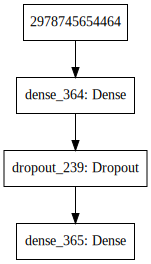

In [1276]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training DNN

In [1277]:
EPOCHS = 400
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/400
90/90 [==============================] - 6s 64ms/step - loss: 1.2703 - acc: 0.3889 - val_loss: 0.9547 - val_acc: 0.6000
Epoch 2/400
90/90 [==============================] - 0s 222us/step - loss: 1.2405 - acc: 0.3667 - val_loss: 0.9292 - val_acc: 0.6667
Epoch 3/400
90/90 [==============================] - 0s 299us/step - loss: 1.1585 - acc: 0.4111 - val_loss: 0.9092 - val_acc: 0.6667
Epoch 4/400
90/90 [==============================] - 0s 244us/step - loss: 1.0645 - acc: 0.5111 - val_loss: 0.8930 - val_acc: 0.6444
Epoch 5/400
90/90 [==============================] - 0s 299us/step - loss: 1.0886 - acc: 0.4889 - val_loss: 0.8748 - val_acc: 0.6889
Epoch 6/400
90/90 [==============================] - 0s 255us/step - loss: 1.0288 - acc: 0.4778 - val_loss: 0.8591 - val_acc: 0.7111
Epoch 7/400
90/90 [==============================] - 0s 310us/step - loss: 1.0774 - acc: 0.5000 - val_loss: 0.8435 - val_acc: 0.7111
Epoch 8/400
90/90 [=======

Epoch 62/400
90/90 [==============================] - 0s 255us/step - loss: 0.4881 - acc: 0.7889 - val_loss: 0.4789 - val_acc: 0.8889
Epoch 63/400
90/90 [==============================] - 0s 266us/step - loss: 0.4807 - acc: 0.8556 - val_loss: 0.4733 - val_acc: 0.8889
Epoch 64/400
90/90 [==============================] - 0s 321us/step - loss: 0.4692 - acc: 0.8778 - val_loss: 0.4669 - val_acc: 0.9111
Epoch 65/400
90/90 [==============================] - 0s 344us/step - loss: 0.4600 - acc: 0.8333 - val_loss: 0.4610 - val_acc: 0.9111
Epoch 66/400
90/90 [==============================] - 0s 366us/step - loss: 0.4638 - acc: 0.8778 - val_loss: 0.4541 - val_acc: 0.9111
Epoch 67/400
90/90 [==============================] - 0s 410us/step - loss: 0.5477 - acc: 0.7889 - val_loss: 0.4547 - val_acc: 0.9111
Epoch 68/400
90/90 [==============================] - 0s 432us/step - loss: 0.4815 - acc: 0.8444 - val_loss: 0.4506 - val_acc: 0.9111
Epoch 69/400
90/90 [==============================] - 0s 454us

Epoch 123/400
90/90 [==============================] - 0s 299us/step - loss: 0.2978 - acc: 0.9111 - val_loss: 0.3010 - val_acc: 0.9111
Epoch 124/400
90/90 [==============================] - 0s 233us/step - loss: 0.3300 - acc: 0.9222 - val_loss: 0.3027 - val_acc: 0.9111
Epoch 125/400
90/90 [==============================] - 0s 344us/step - loss: 0.3005 - acc: 0.9333 - val_loss: 0.2970 - val_acc: 0.9111
Epoch 126/400
90/90 [==============================] - 0s 366us/step - loss: 0.3067 - acc: 0.9222 - val_loss: 0.2928 - val_acc: 0.9111
Epoch 127/400
90/90 [==============================] - 0s 377us/step - loss: 0.3177 - acc: 0.8889 - val_loss: 0.2921 - val_acc: 0.9111
Epoch 128/400
90/90 [==============================] - 0s 299us/step - loss: 0.3395 - acc: 0.9222 - val_loss: 0.2925 - val_acc: 0.9111
Epoch 129/400
90/90 [==============================] - 0s 343us/step - loss: 0.2664 - acc: 0.9222 - val_loss: 0.2898 - val_acc: 0.9111
Epoch 130/400
90/90 [==============================] - 

Epoch 184/400
90/90 [==============================] - 0s 277us/step - loss: 0.2143 - acc: 0.9222 - val_loss: 0.2148 - val_acc: 0.9111
Epoch 185/400
90/90 [==============================] - 0s 255us/step - loss: 0.2548 - acc: 0.9444 - val_loss: 0.2176 - val_acc: 0.9111
Epoch 186/400
90/90 [==============================] - 0s 321us/step - loss: 0.2396 - acc: 0.9222 - val_loss: 0.2138 - val_acc: 0.9111
Epoch 187/400
90/90 [==============================] - 0s 399us/step - loss: 0.2699 - acc: 0.9111 - val_loss: 0.2126 - val_acc: 0.9111
Epoch 188/400
90/90 [==============================] - 0s 432us/step - loss: 0.1907 - acc: 0.9333 - val_loss: 0.2099 - val_acc: 0.9111
Epoch 189/400
90/90 [==============================] - 0s 266us/step - loss: 0.2280 - acc: 0.9222 - val_loss: 0.2096 - val_acc: 0.9111
Epoch 190/400
90/90 [==============================] - 0s 355us/step - loss: 0.2128 - acc: 0.9333 - val_loss: 0.2105 - val_acc: 0.9111
Epoch 191/400
90/90 [==============================] - 

Epoch 245/400
90/90 [==============================] - 0s 299us/step - loss: 0.1552 - acc: 0.9444 - val_loss: 0.1760 - val_acc: 0.9111
Epoch 246/400
90/90 [==============================] - 0s 366us/step - loss: 0.1490 - acc: 0.9556 - val_loss: 0.1726 - val_acc: 0.9111
Epoch 247/400
90/90 [==============================] - 0s 399us/step - loss: 0.1278 - acc: 0.9444 - val_loss: 0.1720 - val_acc: 0.9111
Epoch 248/400
90/90 [==============================] - 0s 310us/step - loss: 0.1387 - acc: 0.9778 - val_loss: 0.1656 - val_acc: 0.9111
Epoch 249/400
90/90 [==============================] - 0s 355us/step - loss: 0.1273 - acc: 0.9667 - val_loss: 0.1683 - val_acc: 0.9111
Epoch 250/400
90/90 [==============================] - 0s 310us/step - loss: 0.1681 - acc: 0.9111 - val_loss: 0.1662 - val_acc: 0.9111
Epoch 251/400
90/90 [==============================] - 0s 266us/step - loss: 0.1534 - acc: 0.9556 - val_loss: 0.1670 - val_acc: 0.9111
Epoch 252/400
90/90 [==============================] - 

Epoch 306/400
90/90 [==============================] - 0s 388us/step - loss: 0.1340 - acc: 0.9556 - val_loss: 0.1728 - val_acc: 0.9556
Epoch 307/400
90/90 [==============================] - 0s 344us/step - loss: 0.1626 - acc: 0.9333 - val_loss: 0.1706 - val_acc: 0.9556
Epoch 308/400
90/90 [==============================] - 0s 454us/step - loss: 0.0989 - acc: 0.9889 - val_loss: 0.1652 - val_acc: 0.9556
Epoch 309/400
90/90 [==============================] - 0s 399us/step - loss: 0.0862 - acc: 0.9889 - val_loss: 0.1615 - val_acc: 0.9556
Epoch 310/400
90/90 [==============================] - 0s 454us/step - loss: 0.1349 - acc: 0.9556 - val_loss: 0.1600 - val_acc: 0.9556
Epoch 311/400
90/90 [==============================] - 0s 388us/step - loss: 0.0647 - acc: 1.0000 - val_loss: 0.1568 - val_acc: 0.9556
Epoch 312/400
90/90 [==============================] - 0s 421us/step - loss: 0.0996 - acc: 0.9778 - val_loss: 0.1573 - val_acc: 0.9556
Epoch 313/400
90/90 [==============================] - 

Epoch 367/400
90/90 [==============================] - 0s 266us/step - loss: 0.0662 - acc: 0.9889 - val_loss: 0.1399 - val_acc: 0.9778
Epoch 368/400
90/90 [==============================] - 0s 366us/step - loss: 0.1129 - acc: 0.9333 - val_loss: 0.1449 - val_acc: 0.9778
Epoch 369/400
90/90 [==============================] - 0s 488us/step - loss: 0.0619 - acc: 0.9889 - val_loss: 0.1446 - val_acc: 0.9778
Epoch 370/400
90/90 [==============================] - 0s 377us/step - loss: 0.0707 - acc: 1.0000 - val_loss: 0.1456 - val_acc: 0.9778
Epoch 371/400
90/90 [==============================] - 0s 410us/step - loss: 0.0613 - acc: 0.9889 - val_loss: 0.1387 - val_acc: 0.9778
Epoch 372/400
90/90 [==============================] - 0s 388us/step - loss: 0.0773 - acc: 0.9889 - val_loss: 0.1407 - val_acc: 0.9778
Epoch 373/400
90/90 [==============================] - 0s 399us/step - loss: 0.0793 - acc: 0.9778 - val_loss: 0.1410 - val_acc: 0.9778
Epoch 374/400
90/90 [==============================] - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


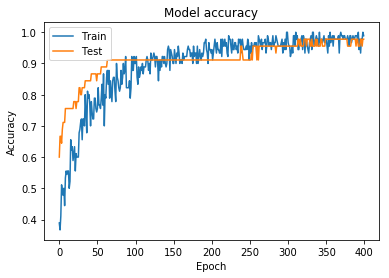

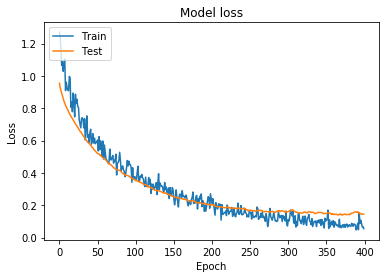

In [1278]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [1279]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'rock_paper_scissors_dct_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [1280]:
del model
model = models.load_model(filename)

## Confirmation

In [1281]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 27)

In [1282]:
layer_outputs = [layer.output for layer in model.layers]

In [1283]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)

In [1284]:
class_labels

['paper', 'rock', 'scissors']

In [1285]:
(activations[-1][:10]*100).astype(int)

array([[ 0, 99,  0],
       [ 0, 96,  2],
       [97,  1,  1],
       [ 2, 33, 63],
       [98,  0,  1],
       [ 0,  0, 99],
       [ 0,  0, 99],
       [ 0,  0, 99],
       [98,  0,  0],
       [58,  1, 40]])

In [1286]:
test_labels[:10].astype(int)

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0]])